<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA6-Phase1/blob/main/06-Normalization%20and%20regularization/Normalization_MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit classification with Batch and L1, Group and Layer normalization

Objective:

1. implement CNN model with Batch Norm and L1 + L2 regularization.
2. implement CNN model with Group Norm + L1
3. implement CNN model with Layer Norm + L2
4. compare the normalization results.
5. capture misclassified images for each of the models.


## Necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

!pip install torchsummary
from torchsummary import summary
from torchvision import transforms, datasets, utils

In [3]:
import model

## Prepare dataset

In [4]:
train_transform = transforms.Compose([
                                      transforms.RandomRotation((-6.9, 6.9), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [5]:
train_dataset = datasets.MNIST(root='../data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=test_transform, download=True)

In [4]:
sample = next(iter(train_dataset))
data, label = sample
print(data.shape, type(data))

torch.Size([1, 28, 28]) <class 'torch.Tensor'>


Dataloader

In [6]:
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

In [7]:
sample_images, sample_labels = next(iter(train_loader))
print(sample_images[:16].shape)

torch.Size([16, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 117, 117])


(-0.5, 116.5, 116.5, -0.5)

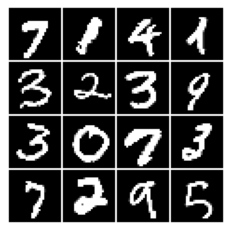

In [8]:
grid_image = utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## Train and Test

In [9]:
# Train

def train(model, device, train_loader, optimizer, criterion, l1_lambda):
    model.train()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_id, batch in enumerate(train_loader):
        data = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()

        # Gather prediction and calculate loss + backward pass + optimize weights
        label_pred = model(data)
        label_loss = criterion(label_pred, target)

        # L1 regularization
        if l1_lambda > 0 :
            l1_criterion = nn.L1Loss(size_average=False)
            l1_reg_loss = 0
            for param in model.parameters():
                l1_reg_loss += l1_criterion(param, torch.zeros_like(param))
                # print("L1 reg loss: ", l1_reg_loss)
            label_loss += l1_lambda * l1_reg_loss
        
        # Calculate gradients
        label_loss.backward()
        # Optimizer
        optimizer.step()

        # Metrics calculation- For epoch Accuracy(total correct pred/total items) and loss 
        pred = label_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        epoch_loss += label_loss.item()
    
    epoch_accuracy = (100*correct/processed)
    epoch_loss /= len(train_loader)
    print(f"Train set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")

    return epoch_accuracy, epoch_loss

In [10]:
# Test
def test(model, device, test_loader, criterion):
    model.eval()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    with torch.no_grad():        
        for batch_id, batch in enumerate(test_loader):
            data = batch[0].to(device)
            target = batch[1].to(device)

            label_pred = model(data)
            label_loss = criterion(label_pred, target)

            # Metrics calculation
            pred = label_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            epoch_loss += label_loss.item()
        
    epoch_accuracy = (100*correct)/processed
    epoch_loss /= len(test_loader)
    print(f"Test set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")
    return epoch_accuracy, epoch_loss

## Model Instantiation and summary of 3 models

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model_BN = model.Net('BatchNorm').to(device)
summary(model_BN, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             128
           Conv2d-11           [-1, 12, 12, 12]             864
             ReLU-12           [-1, 12, 12, 12]               0
      BatchNorm2d-13           [-1, 12, 12, 12]              24
          Dropou

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model_GN = model.Net("GroupNorm").to(device)
summary(model_GN, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             128
           Conv2d-11           [-1, 12, 12, 12]             864
             ReLU-12           [-1, 12, 12, 12]               0
        GroupNorm-13           [-1, 12, 12, 12]              24
          Dropou

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model_LN = model.Net("LayerNorm").to(device)
summary(model_LN, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             128
           Conv2d-11           [-1, 12, 12, 12]             864
             ReLU-12           [-1, 12, 12, 12]               0
        GroupNorm-13           [-1, 12, 12, 12]              24
          Dropou

## Model execution

In [14]:
def train_model(model, l1_lambda=0, l2_lambda=0):
    EPOCHS = 20
    train_accuracy = []
    test_accuracy = []
    train_loss = []
    test_loss = []

    # Optimization algorithm from torch.optim
    optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9, weight_decay=l2_lambda)
    # Loss condition
    criterion = nn.CrossEntropyLoss()

    for epochs in range(EPOCHS):
        print(f"Epoch: {epochs}")
        train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion, l1_lambda)
        test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)

        train_accuracy.append(round(train_acc_delta, 2))
        train_loss.append(round(train_loss_delta, 4))
        test_accuracy.append(round(test_acc_delta, 2))
        test_loss.append(round(test_loss_delta, 4))
    return train_accuracy, train_loss, test_accuracy, test_loss

### With Batch Norm + L1 regularization

In [15]:
train_accuracy_BN, train_loss_BN, test_accuracy_BN, test_loss_BN = train_model(model_BN, l1_lambda = 0.0001, l2_lambda = 0.001)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train set: Epoch Accuracy: 92.2  Epoch Loss: 0.3275
Test set: Epoch Accuracy: 97.48  Epoch Loss: 0.0828
Epoch: 1
Train set: Epoch Accuracy: 97.78  Epoch Loss: 0.1335
Test set: Epoch Accuracy: 97.97  Epoch Loss: 0.0646
Epoch: 2
Train set: Epoch Accuracy: 98.12  Epoch Loss: 0.1198
Test set: Epoch Accuracy: 98.47  Epoch Loss: 0.0498
Epoch: 3
Train set: Epoch Accuracy: 98.14  Epoch Loss: 0.1138
Test set: Epoch Accuracy: 98.69  Epoch Loss: 0.0467
Epoch: 4
Train set: Epoch Accuracy: 98.14  Epoch Loss: 0.112
Test set: Epoch Accuracy: 98.61  Epoch Loss: 0.0532
Epoch: 5
Train set: Epoch Accuracy: 98.21  Epoch Loss: 0.1104
Test set: Epoch Accuracy: 98.63  Epoch Loss: 0.046
Epoch: 6
Train set: Epoch Accuracy: 98.27  Epoch Loss: 0.1081
Test set: Epoch Accuracy: 98.72  Epoch Loss: 0.0449
Epoch: 7
Train set: Epoch Accuracy: 98.2  Epoch Loss: 0.1101
Test set: Epoch Accuracy: 98.62  Epoch Loss: 0.048
Epoch: 8
Train set: Epoch Accuracy: 98.18  Epoch Loss: 0.1079
Test set: Epoch Accuracy: 98.07  Epoch L

### With Group Normalization

In [16]:
train_accuracy_GN, train_loss_GN, test_accuracy_GN, test_loss_GN = train_model(model_GN, l1_lambda = 0.0001)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train set: Epoch Accuracy: 88.78  Epoch Loss: 0.4469
Test set: Epoch Accuracy: 97.51  Epoch Loss: 0.0772
Epoch: 1
Train set: Epoch Accuracy: 97.56  Epoch Loss: 0.1588
Test set: Epoch Accuracy: 98.67  Epoch Loss: 0.0446
Epoch: 2
Train set: Epoch Accuracy: 98.09  Epoch Loss: 0.1402
Test set: Epoch Accuracy: 98.82  Epoch Loss: 0.041
Epoch: 3
Train set: Epoch Accuracy: 98.25  Epoch Loss: 0.1318
Test set: Epoch Accuracy: 98.8  Epoch Loss: 0.0401
Epoch: 4
Train set: Epoch Accuracy: 98.38  Epoch Loss: 0.1287
Test set: Epoch Accuracy: 98.94  Epoch Loss: 0.0352
Epoch: 5
Train set: Epoch Accuracy: 98.46  Epoch Loss: 0.1245
Test set: Epoch Accuracy: 98.87  Epoch Loss: 0.0388
Epoch: 6
Train set: Epoch Accuracy: 98.46  Epoch Loss: 0.1235
Test set: Epoch Accuracy: 99.14  Epoch Loss: 0.0303
Epoch: 7
Train set: Epoch Accuracy: 98.55  Epoch Loss: 0.1222
Test set: Epoch Accuracy: 98.83  Epoch Loss: 0.0378
Epoch: 8
Train set: Epoch Accuracy: 98.5  Epoch Loss: 0.1203
Test set: Epoch Accuracy: 98.84  Epoch

### With Layer Normalization

In [17]:
train_accuracy_LN, train_loss_LN, test_accuracy_LN, test_loss_LN = train_model(model_LN, l2_lambda = 0.001)

Epoch: 0
Train set: Epoch Accuracy: 91.62  Epoch Loss: 0.2887
Test set: Epoch Accuracy: 98.62  Epoch Loss: 0.0482
Epoch: 1
Train set: Epoch Accuracy: 97.8  Epoch Loss: 0.0798
Test set: Epoch Accuracy: 98.81  Epoch Loss: 0.0451
Epoch: 2
Train set: Epoch Accuracy: 98.11  Epoch Loss: 0.0672
Test set: Epoch Accuracy: 98.89  Epoch Loss: 0.0409
Epoch: 3
Train set: Epoch Accuracy: 98.17  Epoch Loss: 0.0645
Test set: Epoch Accuracy: 98.4  Epoch Loss: 0.0514
Epoch: 4
Train set: Epoch Accuracy: 98.28  Epoch Loss: 0.0615
Test set: Epoch Accuracy: 98.93  Epoch Loss: 0.0353
Epoch: 5
Train set: Epoch Accuracy: 98.31  Epoch Loss: 0.0586
Test set: Epoch Accuracy: 99.07  Epoch Loss: 0.0323
Epoch: 6
Train set: Epoch Accuracy: 98.36  Epoch Loss: 0.0563
Test set: Epoch Accuracy: 98.93  Epoch Loss: 0.0331
Epoch: 7
Train set: Epoch Accuracy: 98.35  Epoch Loss: 0.0573
Test set: Epoch Accuracy: 98.85  Epoch Loss: 0.0433
Epoch: 8
Train set: Epoch Accuracy: 98.39  Epoch Loss: 0.0561
Test set: Epoch Accuracy: 99

## Run results

<Figure size 432x288 with 0 Axes>

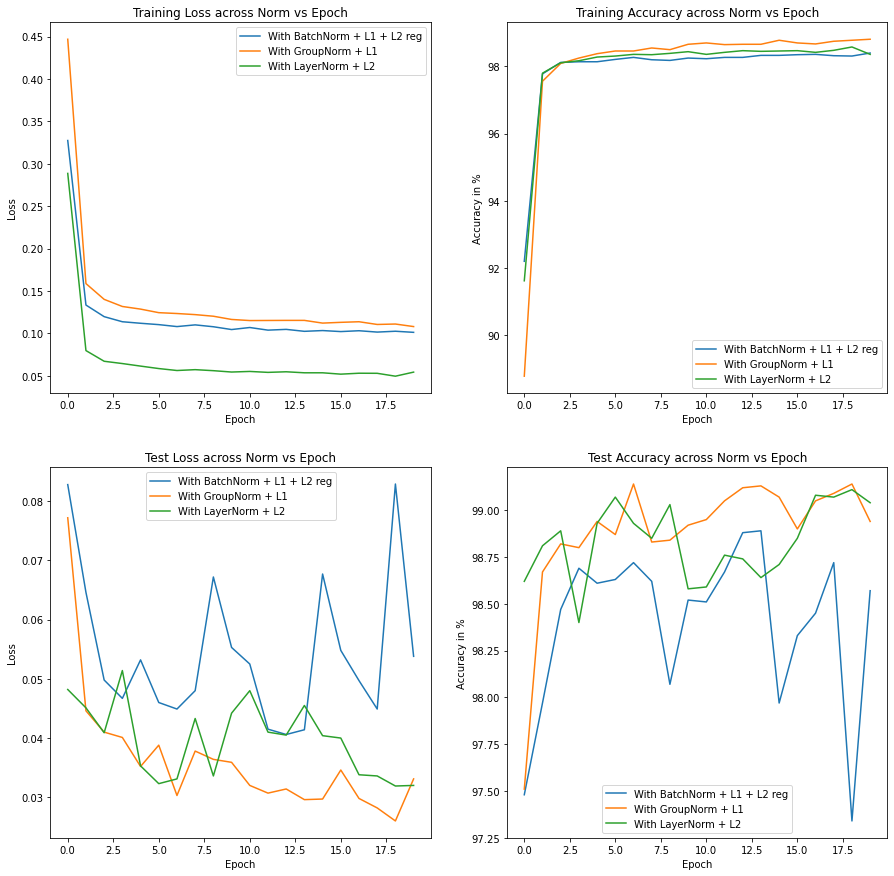

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,15))

axs[0][0].set_title("Training Loss across Norm vs Epoch")
axs[0][0].plot(train_loss_BN, label="With BatchNorm + L1 + L2 reg")
axs[0][0].plot(train_loss_GN, label="With GroupNorm + L1")
axs[0][0].plot(train_loss_LN, label="With LayerNorm + L2")
axs[0][0].set_xlabel("Epoch")
axs[0][0].set_ylabel("Loss")
axs[0][0].legend(loc="best")

axs[0][1].set_title("Training Accuracy across Norm vs Epoch")
axs[0][1].plot(train_accuracy_BN, label="With BatchNorm + L1 + L2 reg")
axs[0][1].plot(train_accuracy_GN, label="With GroupNorm + L1")
axs[0][1].plot(train_accuracy_LN, label="With LayerNorm + L2")
axs[0][1].set_xlabel("Epoch")
axs[0][1].set_ylabel("Accuracy in %")
axs[0][1].legend(loc="best")

axs[1][0].set_title("Test Loss across Norm vs Epoch")
axs[1][0].plot(test_loss_BN, label="With BatchNorm + L1 + L2 reg")
axs[1][0].plot(test_loss_GN, label="With GroupNorm + L1")
axs[1][0].plot(test_loss_LN, label="With LayerNorm + L2")
axs[1][0].set_xlabel("Epoch")
axs[1][0].set_ylabel("Loss")
axs[1][0].legend(loc="best")

axs[1][1].set_title("Test Accuracy across Norm vs Epoch")
axs[1][1].plot(test_accuracy_BN, label="With BatchNorm + L1 + L2 reg")
axs[1][1].plot(test_accuracy_GN, label="With GroupNorm + L1")
axs[1][1].plot(test_accuracy_LN, label="With LayerNorm + L2")
axs[1][1].set_xlabel("Epoch")
axs[1][1].set_ylabel("Accuracy in %")
axs[1][1].legend(loc="best")

plt.figure()

### Misclassified Images

In [19]:
def capture_incorrect_classified_samples(net, device, testloader):
    """
    Captures incorrect sample data- such as labels, predictions and images
    Input
        net - model
        device - device to run the model
        testloader - testloader
    """
    net.eval()
    incorrect_labels = torch.tensor([], dtype = torch.long)
    incorrect_predictions = torch.tensor([], dtype = torch.long)
    incorrect_images = torch.tensor([])

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            result = predicted.eq(labels.view_as(predicted))

            # Incorrect labels, images and predictions           
            incorrect_labels = torch.cat((incorrect_labels,labels[~result].cpu()), dim=0)
            incorrect_predictions = torch.cat((incorrect_predictions, predicted[~result].cpu()), dim=0)
            incorrect_images = torch.cat((incorrect_images, images[~result].cpu()), dim=0)

            # Get out once we have 25 results.
            if incorrect_labels.shape[0] >=25:
                break

        return incorrect_labels.numpy(), incorrect_predictions.numpy(), incorrect_images

In [28]:
def show_incorrect_images(label_wrong, pred_wrong, image_wrong):
    i = 1
    nrows = 5
    ncols = 4
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,10))
    for row in range(nrows):
        for col in range(ncols):
            ax[row, col].imshow(image_wrong[i].cpu().numpy().squeeze(), cmap='gray_r')
            ax[row, col].set_title("Predicted Label:{}\nTrue Label:{}".format(pred_wrong[i], label_wrong[i]))
            i += 1 
    plt.tight_layout()   

### For BatchNorm + L1 + L2

In [21]:
label_BN, prediction_BN, images_BN = capture_incorrect_classified_samples(model_BN, device, test_loader)

In [22]:
images_BN.shape

torch.Size([27, 1, 28, 28])

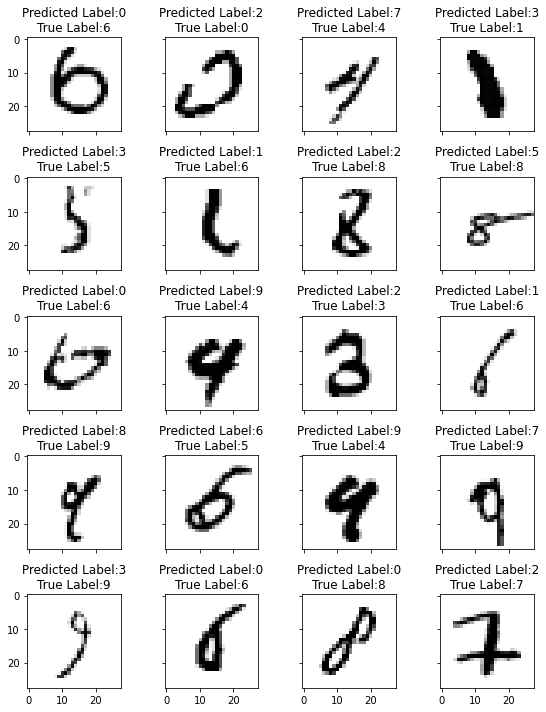

In [29]:
show_incorrect_images(label_BN, prediction_BN, images_BN)

### For Group Norm + L1

In [24]:
label_GN, prediction_GN, images_GN = capture_incorrect_classified_samples(model_GN, device, test_loader)

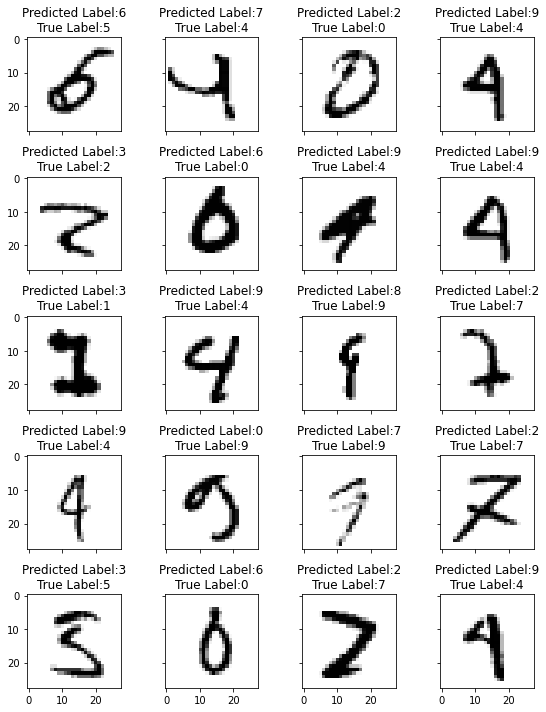

In [30]:
show_incorrect_images(label_GN, prediction_GN, images_GN)

### For Layer Norm + L2

In [31]:
label_LN, prediction_LN, images_LN = capture_incorrect_classified_samples(model_LN, device, test_loader)

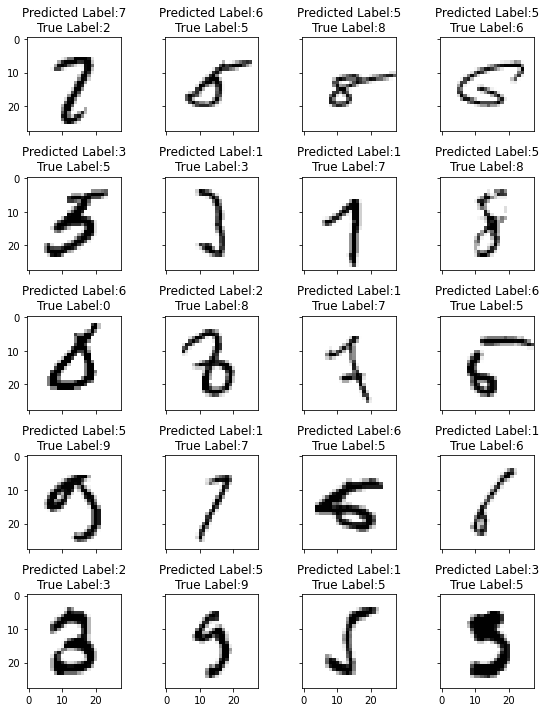

In [32]:
show_incorrect_images(label_LN, prediction_LN, images_LN)